# Area Under the ROC Curve

In this notebook, we will have a close look at the Receiver Operator Curve, and the Area Under the Curve metric. We also will take a deep dive into the mathematics and give a fast alternative way of computing the AUC.

We create a (rather bad) classifier, identifying the _versicolor_ flowers from the iris dataset.

#### Load packages

In [1]:
import numpy as np
import pandas as pd
from sklearn.linear_model import LogisticRegression
from sklearn.cross_validation import cross_val_score, train_test_split
from matplotlib import pyplot as plt
import seaborn
%matplotlib inline

#### Load data

In [2]:
path_to_repo = '/Users/ruben/repo/personal/ga/DAT-23-NYC/'
column_headers = ['sepal_length', 'sepal_width', 'petal_length', 'petal_width', 'species']
data = pd.read_csv(path_to_repo + 'data/iris/iris.csv', header=None, names=column_headers)

Add a binary label: versicolor or not versicolor?

In [3]:
data["versicolor"] = data.species == "versicolor"
features = ['sepal_length', 'sepal_width', 'petal_length', 'petal_width']
X, y = data[features], data.versicolor 

#### Train and test model

In [4]:
model = LogisticRegression()
print "%-10s: %.4f" % ("Baseline", (y == 0).mean())
for metric in ["accuracy", "precision", "recall", "f1", "roc_auc"]:
    print "%-10s: %.4f" % (metric, cross_val_score(model, X, y, scoring=metric).mean())

Baseline  : 0.6667
accuracy  : 0.6048
precision : 0.6238
recall    : 0.3051
f1        : 0.3117
roc_auc   : 0.6271


### What is the Receiver Operator Curve?

#### Specifying a cut-off

Let's train the model and looks at its predicted probabilities.

In [5]:
model.fit(X, y)
y_pred_proba = np.array(zip(*model.predict_proba(X))[1])
y_pred_proba[:10]

array([ 0.13458455,  0.24159984,  0.16725767,  0.20241993,  0.11276896,
        0.07726017,  0.11427412,  0.1564567 ,  0.23287197,  0.24830141])

When we make this model into an actual classifier, we need to round these decimal numbers to 0 or 1.

By default, a threshold of 50% is not a bad choice. This is what happens if you call `LogisticRegression`'s own `predict` method.

In [6]:
(model.predict(X) == (y_pred_proba > .5)).all()

True

#### Varying the cut-off

This cut-off is rather arbitrary though. Maybe our model is too precise (not flagging enough cases), or too sensitive (flagging too many cases). 

We could vary this threshold from 0 to 1 and see how the model's performance is changing. The metrics in the ROC curve are the _true positive rate_ (TPR) and _false positive rate_ (FPR):
- True positive rate: TPR = TP / (TP + FN)
  - Also called Recall, Sensitivity, or hit rate 
  - Of all positive cases, how many did I correctly identify?
- False positive rate: FPR = FP / (FP + TN)
  - Also called Fall-out (or 1 - _specifity_)
  - Of all negative cases, how many did I incorrectly identify as positive?
   
Please note we are not using cross validation for readability's sake.

In [7]:
# Set the thresholds between each possible prediction outcome
steps = (y_pred_proba[1:] - y_pred_proba[:-1]) / 2
thresholds = y_pred_proba[:-1] + steps
thresholds = np.sort(np.concatenate([[0, .001], thresholds, [.999, 1]]))

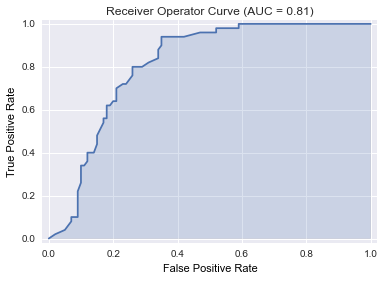

In [8]:
tpr, fpr = [], []
for cutoff in thresholds:
    y_pred = y_pred_proba > cutoff
    tpr.append(y_pred[y.values].mean())  # TPR = % corrects out of all true positives
    fpr.append(y_pred[~y.values].mean())  # FPR = % incorrects out of all true negatives
tpr, fpr = np.array(tpr), np.array(fpr)
auc = (.5 * (tpr[:-1] + tpr[1:]) * (fpr[:-1] - fpr[1:])).sum()  # compute AUC
f = plt.title("Receiver Operator Curve (AUC = %.2f)" % auc)
f = plt.xlabel("False Positive Rate"), plt.ylabel("True Positive Rate")
eps = .02
f = plt.xlim(-eps, 1+eps), plt.ylim(-eps, 1+eps)
f = plt.plot(fpr, tpr)  # plot ROC curve
f = plt.fill_between(fpr, tpr, 0, alpha=.2)  # fill AUC

### Interpreting the ROC curve

We see, a **threshold of 0** will make all our predictions positive: that model is not at all precise, but has a 100% recall (TPR), since we at least did not miss any positive cases. Also we incorrectly identified all negative cases, so the FPR is 100% as well.

In [9]:
y_pred = y_pred_proba > 0
print y_pred[y.values].mean(),  # TPR = % corrects out of all true positives
print y_pred[~y.values].mean()  # FPR = % incorrects out of all true negatives

1.0 1.0


Alternatively, a **threshold of 1** will make all our predictions negative: that model is _too_ precise, with a recall of zero (TPR), since it missed all positive cases. On the upside, all the negative cases were correctly identified as such, so the FPR is 0% as well.

In [10]:
y_pred = y_pred_proba > 1
print y_pred[y.values].mean(),  # TPR = % corrects out of all true positives
print y_pred[~y.values].mean()  # FPR = % incorrects out of all true negatives

0.0 0.0


If nothing crazy is happening, you'd expect the _true_ positive rate always to be higher than the _false_ positive rate: if your model identifies a cases as postive, you'd at least expect that it has a higher _chance_ of indeed being positive than being negative.

Therefore, sometimes you'd look at the _difference_ between TPR and FPR for determining what the best cut-off would be. We plot this difference below.

Ideally, for any threshold, the false positive rate stays very low, while the true positive rate stays very high. So you'd like the curve to be _above_ the diagonal (which it is in this example). In the perfect case, you'd have a vertical line on the left, and a horizontal line on top, with the entire square as the AUC, which then would be equal to 1.

One common way to interpret the Area Under the Curve is in terms of probability: the AUC is equal to **the probability that a randomly chosen positive instance is ranked higher than a randomly chosen negative one**. This turns out to be a very useful interpretation of the AUC.  See below for a mathematical proof of this interpretation.

###Impact of thresholds on other metrics

Let's plot the TPR (aka recall), FPR, and their difference, precision, F1 score and accuracy of a function of the varying threshold.

First, let's vary this threshold and compute all metioned classification metrics on the predictions.

In [11]:
scores = []
for cutoff in thresholds:
    y_pred = y_pred_proba > cutoff
    scores.append({
        'TPR / Recall': y_pred[y.values].mean(),  # TPR = % corrects out of all true positives
        'FPR': y_pred[~y.values].mean(),  # FPR = % incorrects out of all true negatives
        'Precision': y[y_pred].mean(),  # precision = % corrects out of all identified
        'Accuracy': (y_pred == y).mean()})  # accuracy
    p, r = scores[-1]['Precision'], scores[-1]['TPR / Recall']
    scores[-1]['F1 score'] = 2 * p * r / (p + r)  # F1 score = 2PR/(P+R)
scores = pd.DataFrame(scores, index=thresholds)
scores['Always 1'], scores['Always 0'] = y.mean(), 1 - y.mean()  # Add naive classifiers as baseline
scores['difference TPR-FPR'] = scores['TPR / Recall'] - scores.FPR

/Users/ruben/anaconda/lib/python2.7/site-packages/numpy/core/_methods.py:59: RuntimeWarning: Mean of empty slice.
  warnings.warn("Mean of empty slice.", RuntimeWarning)


Now let's plot all these metrics as function of this threshold.

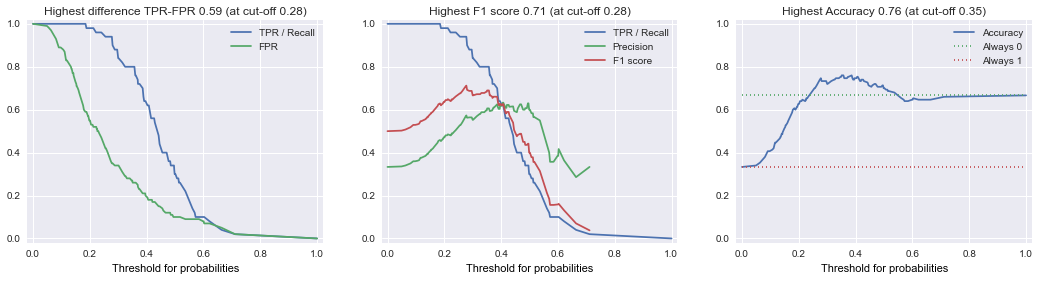

In [12]:
fig, axes = plt.subplots(1, 3, figsize=(18,4))
scores[['TPR / Recall', 'FPR']].plot(legend=True, ylim=(-.02, 1.02), ax=axes[0])
scores[['TPR / Recall', 'Precision', 'F1 score']].plot(legend=True, ylim=(-.02, 1.02), ax=axes[1])
scores[['Accuracy', 'Always 0', 'Always 1']].plot(ax=axes[2], style=list("-::"))
axes[0].set_title("TPR and FPR for increasing thresholds")
for i, metric in enumerate(['difference TPR-FPR', 'F1 score', 'Accuracy']):
    axes[i].set_xlim(-eps, 1+eps), axes[i].set_ylim(-eps, 1+eps), axes[i].set_xlabel('Threshold for probabilities')
    axes[i].set_title("Highest %-8s %.2f (at cut-off %.2f)" % 
                      (metric, scores[metric].max(), scores[metric].argmax()))

Note that
- we get different optimal thresholds depending on which metric we choose, but
- we definitely could obtain higher accuracies than the default cut-off at 50%.

###Standard tools from `sklearn`

Of course, `sklearn` has standard tools for this.

In [13]:
from sklearn.metrics import roc_auc_score, roc_curve

####Without cross-validation
Let's first look at this without cross-validation.

In [14]:
print roc_auc_score(y, y_pred_proba)  # not cross-validated AUC

0.8118


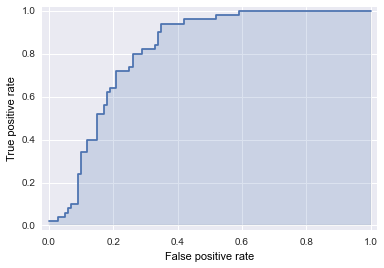

In [15]:
fpr, tpr, thresholds = roc_curve(y, y_pred_proba)
f = plt.plot(fpr, tpr)  # plot ROC curve
f = plt.fill_between(fpr, tpr, 0, alpha=.2)  # fill AUC
f = plt.xlim(-eps, 1+eps), plt.ylim(-eps, 1+eps)
f = plt.xlabel('False positive rate'), plt.ylabel('True positive rate')

Note that the plot looks a bit different than ours, since it doesn't allow for diagonal lines. All lines are either horizontal or vertical.

####With cross-validation
Let's now take a look at cross-validation. We already saw `cross_val_score` with `scoring='roc_auc'`.

In [16]:
print cross_val_score(model, X, y, cv=10, scoring='roc_auc').mean()  # cross-validated AUC

0.786


In [17]:
aucs = []
for i in xrange(100):
    X_train, X_test, y_train, y_test = train_test_split(X, y, train_size=.8)
    aucs.append(roc_auc_score(y_test, zip(*model.fit(X_train, y_train).predict_proba(X_test))[1]))
print np.mean(aucs)  # cross-validated AUC

0.798312471026


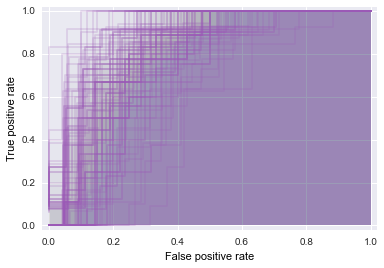

In [18]:
for i in xrange(100):
    X_train, X_test, y_train, y_test = train_test_split(X, y, train_size=.8)
    fpr, tpr, thresholds = roc_curve(y_test, zip(*model.fit(X_train, y_train).predict_proba(X_test))[1])
    f = plt.plot(fpr, tpr, "#9b59b6", alpha=.2)
    f = plt.fill_between(fpr, tpr, 0, color="#9b59b6", alpha=.005)  # fill AUC
f = plt.xlim(-eps, 1+eps), plt.ylim(-eps, 1+eps)    
f = plt.xlabel('False positive rate'), plt.ylabel('True positive rate')

###Simulating some ROC curves
Let's simulate some data to see its effects on the ROC curve and the AUC metric.

In [19]:
N = 1000
y_ground_truth_proba = np.random.random(N)
y_observed = y_ground_truth_proba > .8  # we now have 20% "true" samples and 80% "false" ones

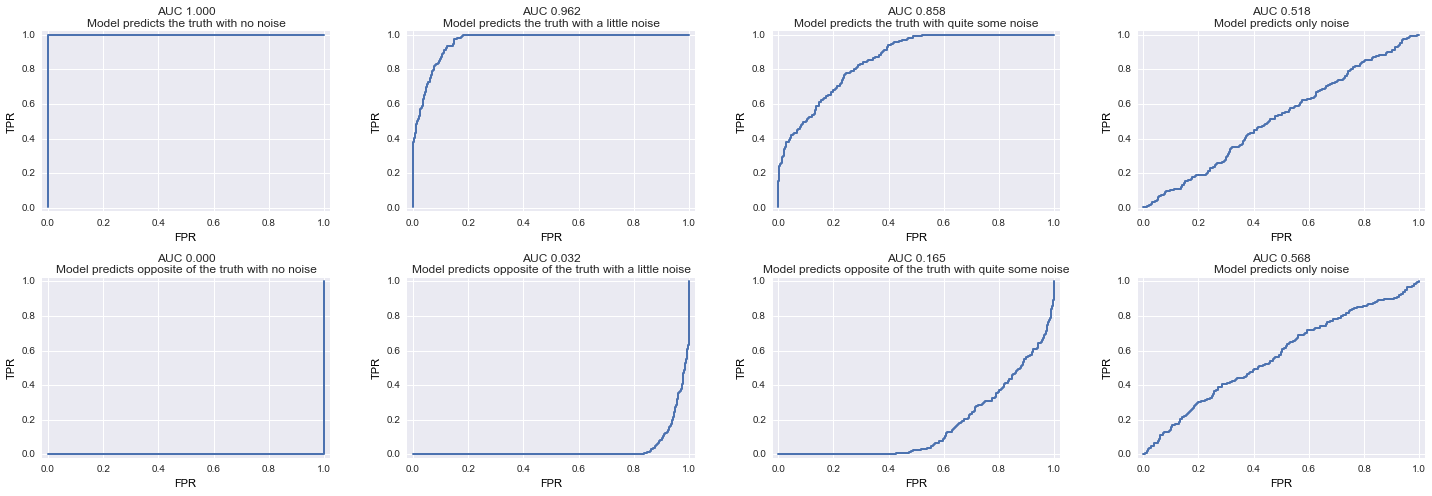

In [20]:
fig, axes = plt.subplots(2, 4, figsize=(20, 7))
for i, sign in enumerate([1, -1]):
    for j, noise in enumerate([0, .3, 1, 100]):
        y_predicted = sign * (y_ground_truth_proba + noise * np.random.random(N))
        ax = axes[i, j]
        ax.plot(*roc_curve(y_observed, y_predicted)[:2], linewidth=2)
        ax.set_title("AUC %.3f\nModel predicts " % roc_auc_score(y_observed, y_predicted) +
            ("opposite of " * (sign == -1) + "the truth with ") * (noise < 2) +
            ["no", "a little", "quite some", "only"][j] + " noise") 
        ax.set_xlim(-eps, 1+eps), ax.set_ylim(-eps, 1+eps), ax.set_xlabel('FPR'), ax.set_ylabel('TPR')
f = plt.tight_layout()

### Wilcoxon statistic

We said earlier that one common way to interpret the Area Under the Curve is in terms of probability: the AUC is equal to **the probability that a randomly chosen positive instance is ranked higher than a randomly chosen negative one**.  This is also sometimes called the _Wilcoxon-Mann-Whitney statistic_. Let's prove that this is actually true.


For a given ROC curve, we compute the AUC as 

\begin{align*}
AUC &= \int_0^1 TPR \space dFPR \\
&= \int_{-\infty}^{\infty}TPR(t) FPR'(t) dt
\end{align*}

Since we have only a finite number of samples we can write

\begin{align*}
TPR(t) &= \frac{1}{p} \sum_{x \text{ pos.}} 1_{\hat y(x) > t } \\
FPR(t) &= \frac{1}{n} \sum_{x \text{ neg.}} 1_{\hat y(x) > t },
\end{align*}

where $p$ and $n$ be the number of respective positive and negative samples. Note that we write $\hat y(x)$ for the model score for sample $x$, i.e., the probability that $x$ is a positive instance. Note we write $\hat y(x)$ for predictions and $y(x)$ for our observations, i.e., the ground truth. In this binary classification case, we only have $y(x) = 1$ for our positive samples, and $y(x) = 0$ for our negative samples. 

It follows that:

\begin{align*}
AUC &= \sum_t 
\big( \frac{1}{p} \sum_{x \text{ pos.}} 1_{\hat y(x) > t } \big)
\big( \frac{1}{n} \sum_{x' \text{ neg.}} 1_{\hat y(x') = t } \big) \\
&= \frac{1}{pn}\sum_t \sum_{x \text{ pos.}} \sum_{x' \text{ neg.}} 1_{\hat y(x) > t }1_{\hat y(x') = t } \\
&= \frac{1}{pn}\sum_{x \text{ pos.}} \sum_{x' \text{ neg.}} \sum_t 1_{\hat y(x) > t }1_{\hat y(x') = t } \\
&= \frac{1}{pn}\sum_{x \text{ pos.}} \sum_{x' \text{ neg.}} 1_{\hat y(x) > \hat y(x') },
\end{align*}

which is exactly the number of pairs of one positive and one negative instance, for which the positive one indeed was ranked higher than the negative one, out of all possible pairs.


###Further reading
You can read more on the [ROC curve on Wikipedia](https://en.wikipedia.org/wiki/Receiver_operating_characteristic).